In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-to-mod/yelp_NYC_2_0.csv
/kaggle/input/yelp-nyc-before-feature-extraction/yelp_nyc.csv
/kaggle/input/yelp-nyc-before-feature-extraction/Распределение_оценок_Нью_Йорк.png
/kaggle/input/yelp-nyc-before-feature-extraction/корреляция_метаданных.png
/kaggle/input/yelp-nyc-before-feature-extraction/топ_30_слов_настоящие.png
/kaggle/input/yelp-nyc-before-feature-extraction/облако_слов_спам.png
/kaggle/input/yelp-nyc-before-feature-extraction/облако_слов_настоящие.png
/kaggle/input/yelp-nyc-before-feature-extraction/Распределение_оценок_Нью_Йорк_с_учетом_рейтинга.png
/kaggle/input/yelp-nyc-before-feature-extraction/Классы_до_балансировки.png
/kaggle/input/yelp-nyc-before-feature-extraction/топ_30_слов_фальшивые.png


# Импорты библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from textblob import TextBlob

nltk.download('vader_lexicon')
nltk.download('brown')
nltk.download('punkt')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Извлечение признаков

## * Чтение датафрейма из csv * 

In [ ]:
df = pd.read_csv('/kaggle/input/yelp-nyc-before-feature-extraction/yelp_nyc.csv').drop('Unnamed: 0', axis=1)
df

**Посчитаем среднюю оценку каждого заведения** 

In [ ]:
avg_mean = df.groupby('prod_name')['rating'].mean().to_frame()
# type(avg_mean)
avg_mean.reset_index(level=0, inplace=True)
avg_mean['rating'] = avg_mean['rating'].apply(lambda x: round(x, 2))
avg_mean.rename(columns={'rating':'avg_prod_rating'}, inplace=True)
avg_mean.head(20)

In [ ]:
print(f'''
Предприятие с минимальным рейтингом: 

{avg_mean.loc[avg_mean['avg_prod_rating'] == min(avg_mean['avg_prod_rating'])]}

Предприятие с максимальным рейтингом:
{avg_mean.loc[avg_mean['avg_prod_rating'] == max(avg_mean['avg_prod_rating'])]}


''')

In [ ]:
df = df.merge(avg_mean, on='prod_name')
df

**Посчитаем средний рейтинг для каждого пользователя**

In [ ]:
avg_mean_per_user = df.groupby('user_id')['rating'].mean().to_frame()
avg_mean_per_user.reset_index(level=0, inplace=True)
avg_mean_per_user['rating'] = avg_mean_per_user['rating'].apply(lambda x: round(x, 2))
avg_mean_per_user.rename(columns={'rating':'avg_user_rating'}, inplace=True)
avg_mean_per_user.head(20)

In [ ]:
df = df.merge(avg_mean_per_user, on='user_id')
df

**Посчитаем длину для каждого отзыва**

In [ ]:
df['review_len'] = df['review'].apply(len)
df

**Посчитаем количество отзывов у каждого пользователя**

In [ ]:
cnt_reviews_per_user = df.groupby('user_id')['review'].count().to_frame()
cnt_reviews_per_user.reset_index(level=0, inplace=True)
# sns.barplot(x=cnt_reviews_per_user['user_id'], y = cnt_reviews_per_user['review'])
cnt_reviews_per_user.rename(columns={'review':'cnt_reviews'}, inplace=True)
cnt_reviews_per_user

In [ ]:
print(f'''
    Максимальное количество отзывов: {cnt_reviews_per_user['cnt_reviews'].max()} 
    
    Минимальное количество отзывов: {cnt_reviews_per_user['cnt_reviews'].min()} 
    
    '''
     )

In [ ]:
df = df.merge(cnt_reviews_per_user, on='user_id')
df

In [ ]:
users_greater_10_reviews = df.loc[df['cnt_reviews'] > 10]
users_greater_10_reviews

In [ ]:
users_greater_10_reviews['label'].value_counts()

In [ ]:
print(
 f'''
 максимальное количество отзывов у спамера: {df.loc[df['label']==-1]['cnt_reviews'].max()}
 максимальное количество отзывов у не спамера: {df.loc[df['label']==1]['cnt_reviews'].max() }
 '''   
)


In [ ]:
users_less_10_reviews = df.loc[df['cnt_reviews'] < 10]
users_less_10_reviews['label'].value_counts()

In [ ]:
users_less_5_reviews = df.loc[df['cnt_reviews'] < 5]
users_less_5_reviews['label'].value_counts()

In [ ]:
users_less_5_reviews = df.loc[df['cnt_reviews'] < 2]
val_cnt = users_less_5_reviews['label'].value_counts()

In [ ]:
def count_users_by_cnt_reviews(thresholds, df):
    for thr in thresholds:
        temp_df = df.loc[df['cnt_reviews'] < thr]['label']
        
        print(f'''
Количество отзывов у пользователей с тоталом меньше {thr}:
{temp_df.value_counts()}
========================================================================
        ''')


In [ ]:
thresholds = [2, 4, 6, 8, 10, 20, 30, 40]
count_users_by_cnt_reviews(thresholds, df)

In [ ]:
# Анализ тональности отзывов

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return analyzer.polarity_scores(text)

analyze_sentiment('This place is so ugly and terrible! I hate it!')

In [ ]:
# reviews_sentiments = df['review'].apply(analyze_sentiment)
reviews_sentiments

In [ ]:
# type(reviews_sentiments)
# reviews_sentiments = reviews_sentiments.to_frame() 
reviews_sentiments_df = pd.json_normalize(reviews_sentiments['review'])
reviews_sentiments_df

In [ ]:
df = df.join(reviews_sentiments_df)

In [ ]:
df.head(20)

In [ ]:
cap_pattern = re.compile(r'\b[A-Z]{2,}\b')
digit_pattern = re.compile(r'\b[0-9]{2,}\b')

df['cap_words'] = df['review'].apply(lambda x: len(cap_pattern.findall(x)))
df['digit_words'] = df['review'].apply(lambda x: len(digit_pattern.findall(x)))
df

**Частеречный анализ отзывов**

In [3]:
df = pd.read_csv('/kaggle/input/yelp-to-mod/yelp_NYC_2_0.csv')

In [4]:
df

,Unnamed: 0,user_id,prod_id,review,rating,label,prod_name,date,avg_prod_rating,avg_user_rating,review_len,cnt_reviews,neg,neu,pos,compound,cap_words,digit_words
0,0,1133,1,My wife and I took my parents there for lunch ...,1.0,-1,Peppino’s,2013-12-21,4.33,1.00,553,1,0.106,0.722,0.172,0.8431,0,0
1,1,1134,1,Got a margarita pizza. First off let me say ve...,1.0,-1,Peppino’s,2013-11-25,4.33,1.00,305,1,0.112,0.813,0.075,-0.5160,1,1
2,2,1135,1,The food is average pizzeria and not cheap. A...,2.0,-1,Peppino’s,2014-07-24,4.33,3.25,157,8,0.085,0.915,0.000,-0.4215,0,0
3,3,1136,1,I can not fathom why people would give this re...,2.0,-1,Peppino’s,2014-03-05,4.33,2.00,766,1,0.027,0.878,0.096,0.8743,0,0
4,4,1137,1,Went here during the time it was busy and i go...,3.0,-1,Peppino’s,2014-11-21,4.33,3.00,185,1,0.000,1.000,0.000,0.0000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358742,358742,161146,349,"I'm very spoiled with Pizza. Really, I have tr...",5.0,1,Emily,2014-02-06,4.19,5.00,1441,1,0.000,0.798,0.202,0.9949,1,1
358743,358743,116424,349,Can't say enough good things about this place....,5.0,1,Emily,2014-01-31,4.19,5.00,475,2,0.043,0.642,0.316,0.9829,0,0
358744,358744,161147,349,"Had a great dinner here- fantastic pizza, the ...",5.0,1,Emily,2014-01-30,4.19,5.00,268,1,0.000,0.605,0.395,0.9788,0,0
358745,358745,97930,349,"Great foods and great drinks, they have even p...",5.0,1,Emily,2014-01-25,4.19,5.00,150,2,0.000,0.474,0.526,0.9682,0,0


In [13]:
# def identify_noun_count(sentence):
#   blob = TextBlob(sentence)
#   return len(blob.noun_phrases)

# df['noun_count'] = df['review'].apply(identify_noun_count)
# df.head(5)

In [19]:
# Функция для подсчёта количества слов по всем частям речи
from collections import defaultdict
def identify_all_pos_counts(sentence):
    blob = TextBlob(sentence)
    pos_counts = defaultdict(int)
    
    # Подсчёт частей речи
    for word, pos in blob.tags:
        pos_counts[pos] += 1
    
    return pos_counts

pos_counts = df['review'].apply(identify_all_pos_counts) 
pos_counts

0         {'PRP$': 3, 'NN': 17, 'CC': 4, 'PRP': 3, 'VBD'...
1         {'NNP': 4, 'DT': 7, 'JJ': 3, 'NN': 9, 'RB': 10...
2         {'DT': 4, 'NN': 4, 'VBZ': 1, 'JJ': 2, 'NNS': 2...
3         {'PRP': 7, 'MD': 4, 'RB': 10, 'VB': 6, 'WRB': ...
4         {'NN': 6, 'RB': 6, 'IN': 2, 'DT': 2, 'PRP': 4,...
                                ...                        
358742    {'PRP': 32, 'VBP': 10, 'RB': 28, 'VBN': 5, 'IN...
358743    {'JJ': 11, 'RB': 7, 'VB': 1, 'NNS': 5, 'IN': 7...
358744    {'VBD': 4, 'DT': 7, 'JJ': 8, 'NN': 11, 'IN': 4...
358745    {'NNP': 1, 'NNS': 4, 'CC': 1, 'JJ': 6, 'PRP': ...
358746    {'NNP': 25, 'CC': 30, 'PRP': 41, 'VBP': 11, 'R...
Name: review, Length: 358747, dtype: object

In [31]:
df_pos = pd.json_normalize(pos_counts)
df_pos.shape

(358747, 36)

In [33]:
df_pos.columns

Index(['PRP$', 'NN', 'CC', 'PRP', 'VBD', 'NNS', 'EX', 'IN', 'VBN', 'DT', 'VBG',
       'RB', 'CD', 'JJ', 'WP', 'TO', 'VB', 'RP', 'VBP', 'MD', 'NNP', 'VBZ',
       'WDT', 'WRB', 'JJR', 'POS', 'RBR', 'JJS', 'UH', 'NNPS', 'PDT', 'RBS',
       'FW', 'LS', 'SYM', 'WP$'],
      dtype='object')

In [37]:
df_pos.isna().sum()
# print(pos_counts.shape)

PRP$    123890
NN        2817
CC       28271
PRP      33732
VBD      76630
NNS      46039
EX      280508
IN       19634
VBN     111292
DT       14100
VBG     133387
RB       19095
CD      155614
JJ        8340
WP      271966
TO      101168
VB       52171
RP      228729
VBP      71528
MD      132364
NNP      65443
VBZ      82888
WDT     236138
WRB     244521
JJR     268371
POS     291621
RBR     303920
JJS     262202
UH      333023
NNPS    352809
PDT     322324
RBS     341815
FW      347314
LS      357802
SYM     353166
WP$     358051
dtype: int64

In [43]:
df_pos = df_pos.fillna(0)
df_pos

,PRP$,NN,CC,PRP,VBD,NNS,EX,IN,VBN,DT,...,RBR,JJS,UH,NNPS,PDT,RBS,FW,LS,SYM,WP$
0,3.0,17.0,4.0,3.0,9.0,5.0,2.0,12.0,4.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,9.0,0.0,3.0,4.0,1.0,0.0,5.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,4.0,2.0,2.0,1.0,2.0,0.0,3.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,29.0,8.0,7.0,7.0,3.0,0.0,11.0,2.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,6.0,3.0,4.0,5.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358742,3.0,37.0,7.0,32.0,15.0,4.0,0.0,26.0,5.0,30.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
358743,1.0,14.0,5.0,5.0,7.0,5.0,0.0,7.0,1.0,11.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
358744,0.0,11.0,3.0,2.0,4.0,0.0,0.0,4.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358745,0.0,3.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
df_copy = df.copy()
df_copy = pd.concat([df_copy, df_pos], axis=1)
df_copy

,Unnamed: 0,user_id,prod_id,review,rating,label,prod_name,date,avg_prod_rating,avg_user_rating,...,RBR,JJS,UH,NNPS,PDT,RBS,FW,LS,SYM,WP$
0,0,1133,1,My wife and I took my parents there for lunch ...,1.0,-1,Peppino’s,2013-12-21,4.33,1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1134,1,Got a margarita pizza. First off let me say ve...,1.0,-1,Peppino’s,2013-11-25,4.33,1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1135,1,The food is average pizzeria and not cheap. A...,2.0,-1,Peppino’s,2014-07-24,4.33,3.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1136,1,I can not fathom why people would give this re...,2.0,-1,Peppino’s,2014-03-05,4.33,2.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1137,1,Went here during the time it was busy and i go...,3.0,-1,Peppino’s,2014-11-21,4.33,3.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358742,358742,161146,349,"I'm very spoiled with Pizza. Really, I have tr...",5.0,1,Emily,2014-02-06,4.19,5.00,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
358743,358743,116424,349,Can't say enough good things about this place....,5.0,1,Emily,2014-01-31,4.19,5.00,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
358744,358744,161147,349,"Had a great dinner here- fantastic pizza, the ...",5.0,1,Emily,2014-01-30,4.19,5.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358745,358745,97930,349,"Great foods and great drinks, they have even p...",5.0,1,Emily,2014-01-25,4.19,5.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


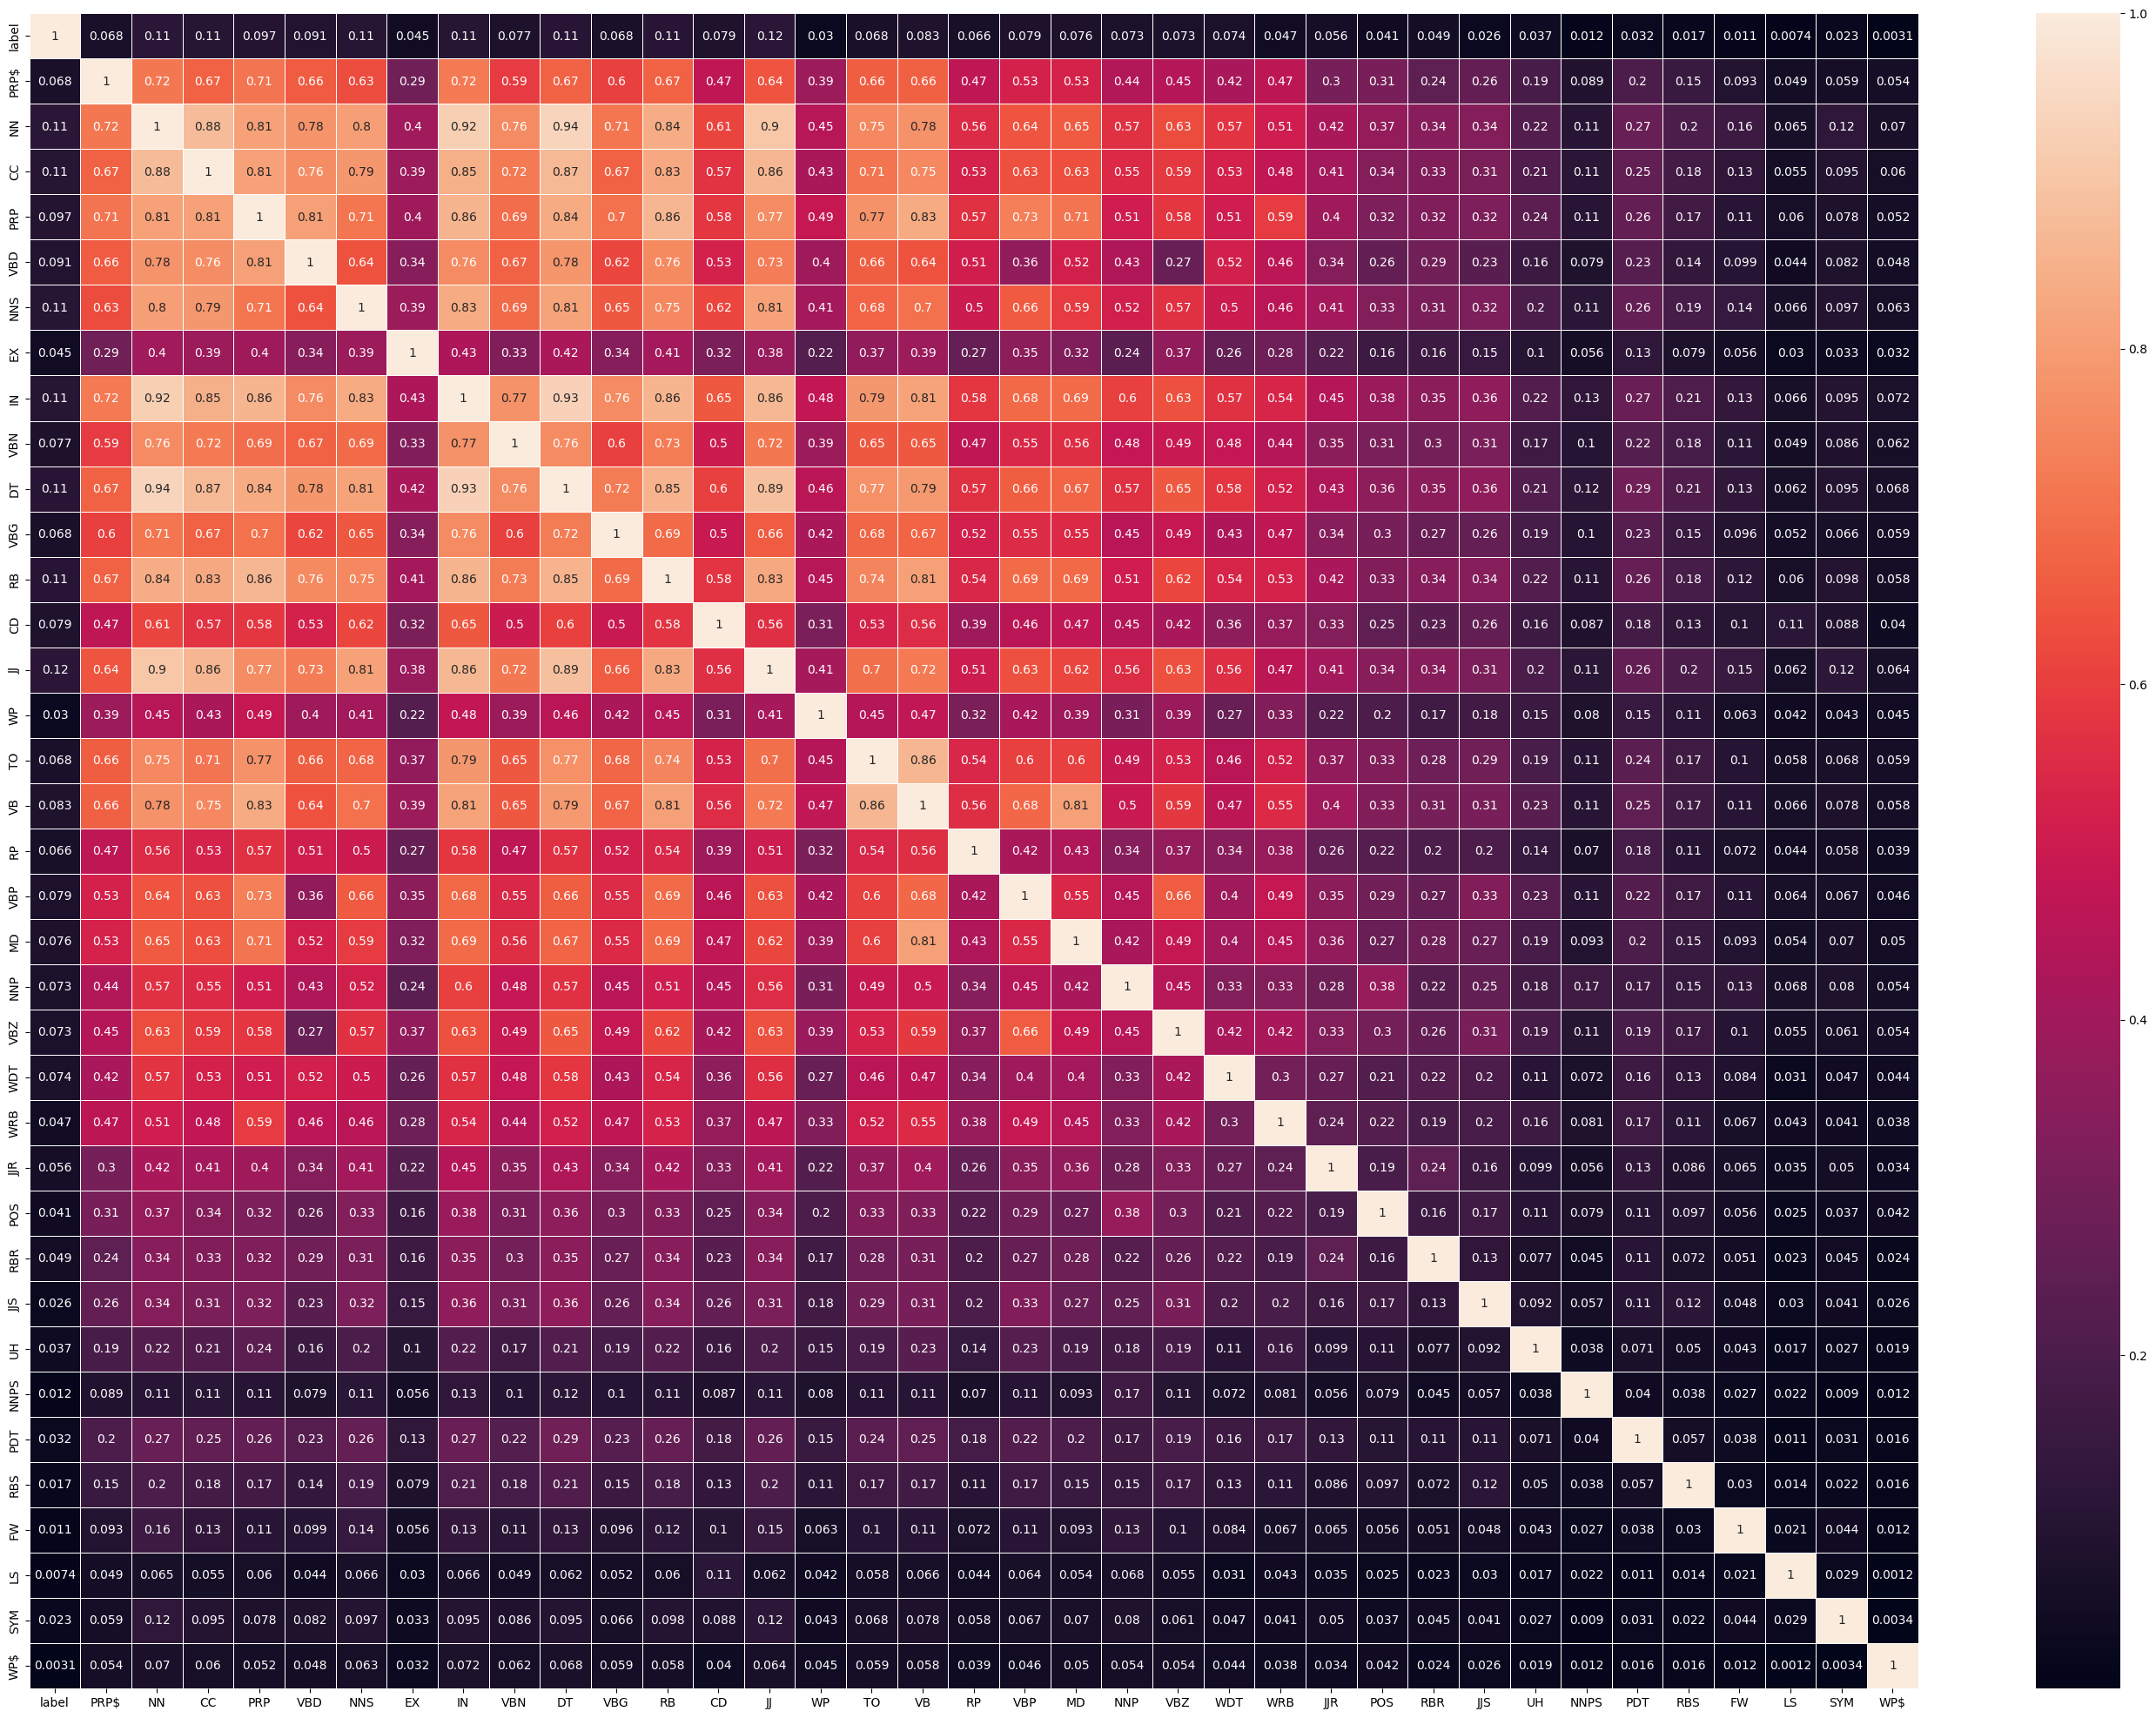

In [48]:
# Матрица корреляции со всеми pos тегами
corr = df_copy.drop(['date', 'prod_name', 'review', 
                     'Unnamed: 0', 'user_id', 'prod_id',
                    'rating', 'avg_prod_rating', 'avg_user_rating', 'review_len',
                    'cnt_reviews', 'neg', 'neu', 'pos', 'compound', 'cap_words', 
                    'digit_words', 'noun_count'], axis=1).corr()

plt.figure(figsize=(35,25))
sns.heatmap(corr, linewidth=0.5, annot=True)
print()

In [51]:
# corr

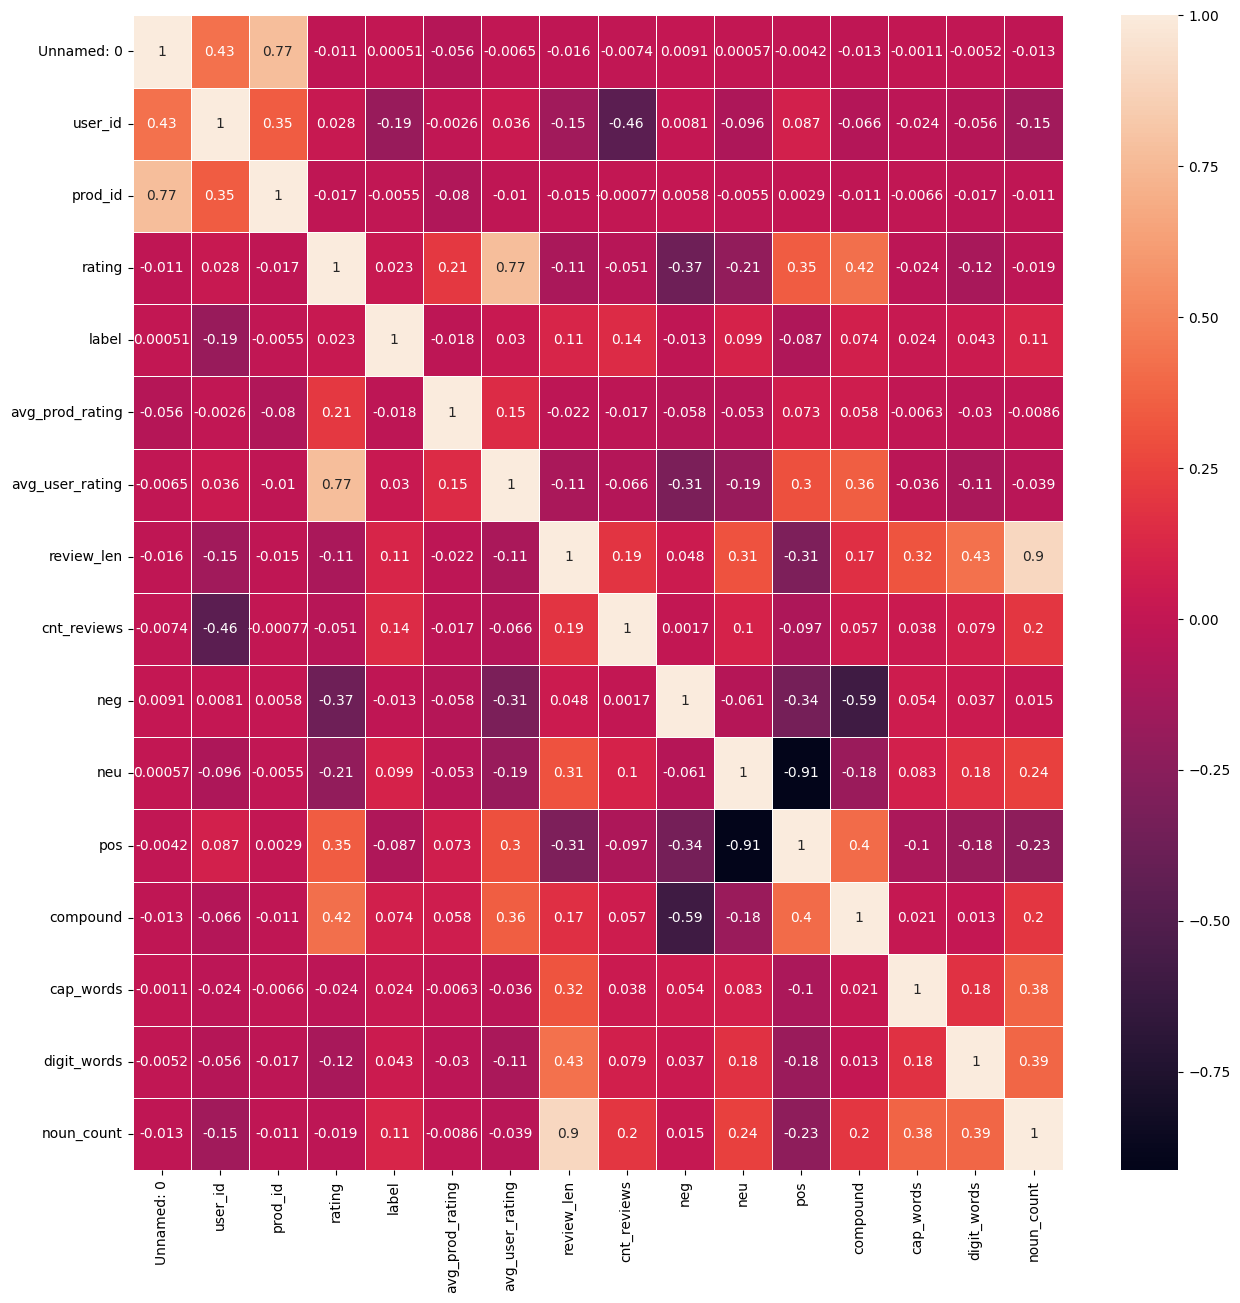

In [12]:
# Матрица корреляции только с количеством существительных
corr = df.drop(['date', 'prod_name', 'review'], axis=1).corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr, linewidth=0.5, annot=True)
print()

In [ ]:
df.to_csv('yelp_NYC_2_0.csv')

In [54]:
df_with_pos = df_copy
df_with_pos.drop('Unnamed: 0', inplace=True, axis = 1)
df_with_pos

,user_id,prod_id,review,rating,label,prod_name,date,avg_prod_rating,avg_user_rating,review_len,...,RBR,JJS,UH,NNPS,PDT,RBS,FW,LS,SYM,WP$
0,1133,1,My wife and I took my parents there for lunch ...,1.0,-1,Peppino’s,2013-12-21,4.33,1.00,553,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1134,1,Got a margarita pizza. First off let me say ve...,1.0,-1,Peppino’s,2013-11-25,4.33,1.00,305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1135,1,The food is average pizzeria and not cheap. A...,2.0,-1,Peppino’s,2014-07-24,4.33,3.25,157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1136,1,I can not fathom why people would give this re...,2.0,-1,Peppino’s,2014-03-05,4.33,2.00,766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1137,1,Went here during the time it was busy and i go...,3.0,-1,Peppino’s,2014-11-21,4.33,3.00,185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358742,161146,349,"I'm very spoiled with Pizza. Really, I have tr...",5.0,1,Emily,2014-02-06,4.19,5.00,1441,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
358743,116424,349,Can't say enough good things about this place....,5.0,1,Emily,2014-01-31,4.19,5.00,475,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
358744,161147,349,"Had a great dinner here- fantastic pizza, the ...",5.0,1,Emily,2014-01-30,4.19,5.00,268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358745,97930,349,"Great foods and great drinks, they have even p...",5.0,1,Emily,2014-01-25,4.19,5.00,150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
df_with_pos.to_csv('yelp_NYC_with_pos_features.csv')